# Akbank Derin Öğrenme Bootcamp: Bulut Sınıflandırma Projesi

Merhabalar! Bu notebook, **Akbank & Global AI Hub** iş birliğiyle düzenlenen Derin Öğrenme Bootcamp'i kapsamında, **Evrişimli Sinir Ağları (CNN)** mimarisi kullanılarak geliştirilen bir görüntü sınıflandırma projesini içermektedir.

Bu çalışmanın amacı, farklı bulut türlerini içeren bir görüntü veri setini kullanarak; veri analizinden modelin yorumlanmasına kadar derin öğrenme projesinin tüm adımlarını uygulamaktır.

### **Yol Haritası**

Bu proje boyunca aşağıdaki adımları izleyeceğiz:

*   **Keşifsel Veri Analizi (EDA):** Veri setimizi tanıyacak ve özelliklerini analiz edeceğiz.
*   **Veri Ön İşleme ve Zenginleştirme (Data Augmentation):** Modelimizin genelleme yeteneğini artırmak için görüntüler üzerinde çeşitli dönüşüm teknikleri uygulayacağız.
*   **Model Geliştirme:** Sıfırdan bir **Evrişimli Sinir Ağı (CNN)** mimarisi tasarlayıp eğiteceğiz.
*   **Hiperparametre Optimizasyonu:** Modelimizin performansını en üst düzeye çıkarmak için en uygun hiperparametreleri arayacağız.
*   **Model Değerlendirme:** Yalnızca doğruluk (accuracy) metriğiyle yetinmeyip, **Karmaşıklık Matrisi (Confusion Matrix)** ve **Sınıflandırma Raporu (Classification Report)** gibi detaylı metriklerle modelimizin başarısını kapsamlı bir şekilde yorumlayacağız.
*   **Modelin Şeffaflığı (XAI):** Geliştirdiğimiz modelin bir "kara kutu" olmasını engelleyeceğiz. **Grad-CAM** gibi görselleştirme teknikleri kullanarak, modelimizin karar verirken görüntünün hangi bölgelerine odaklandığını görsel olarak analiz edeceğiz.

Temel kütüphanelerimizi yükleyerek projeme başlayalım!

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

## 📝 Adım 1: Veri Setini Anlama ve Keşifsel Veri Analizi (EDA)

Her başarılı makine öğrenmesi projesi, eldeki veriyi derinlemesine anlamakla başlar. Bir şefin yemek yapmadan önce malzemelerini kontrol etmesi gibi, biz de modelimizi eğitmeden önce "ham maddemiz" olan görüntü veri setini tanımalıyız. Bu sürece Keşifsel Veri Analizi (Exploratory Data Analysis - EDA) diyoruz.

Bu bölümde, aşağıdaki temel sorulara cevap arayacağız:
* Veri setimizdeki sınıflar (bulut türleri) nelerdir?
* Her sınıfta kaçar tane görsel var? Sınıflar arasında bir dengesizlik mevcut mu?
* Farklı sınıflara ait görseller görsel olarak neye benziyor? Problemin zorluk derecesi hakkında ne gibi ipuçları veriyorlar?

Aşağıdaki kod bloğu, bu soruları cevaplamak için üç temel adımı gerçekleştirir:
* **Veri Setine Erişim:** Öncelikle, Kaggle ortamındaki veri setimizin dosya yollarını tanımlayarak projemize dahil ediyoruz.
* **Sınıf Dağılımının Analizi**: Her bir bulut türüne ait görsel sayısını hesaplayıp bir bar grafiği ile görselleştiriyoruz. Bu grafik, veri setimizdeki olası bir sınıf dengesizliği (class imbalance) problemini erkenden tespit etmemizi sağlar. Eğer bir sınıf diğerlerinden çok daha fazla örneğe sahipse, modelimiz o sınıfa karşı yanlı (biased) olabilir ve azınlıkta kalan sınıfları öğrenmekte zorlanabilir.
* **Görsel Keşif:** Sayısal analizden sonra, her sınıftan rastgele birkaç örnek görseli ekrana çizdirerek verimize "gözlerimizle" bakıyoruz. Bu adım, sınıfların görsel olarak ne kadar ayırt edici olduğunu, birbirlerine ne kadar benzediklerini ve genel görüntü kalitesini anlamamıza yardımcı olur.
Bu ilk analiz, projemizin sonraki adımlarında (örneğin veri zenginleştirme ihtiyacı veya doğru değerlendirme metriklerinin seçimi gibi) vereceğimiz kararlar için bize yol gösterecektir.

Eğitim setindeki (clouds_train) sınıf dağılımı analiz ediliyor...
Bulunan Sınıflar: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']


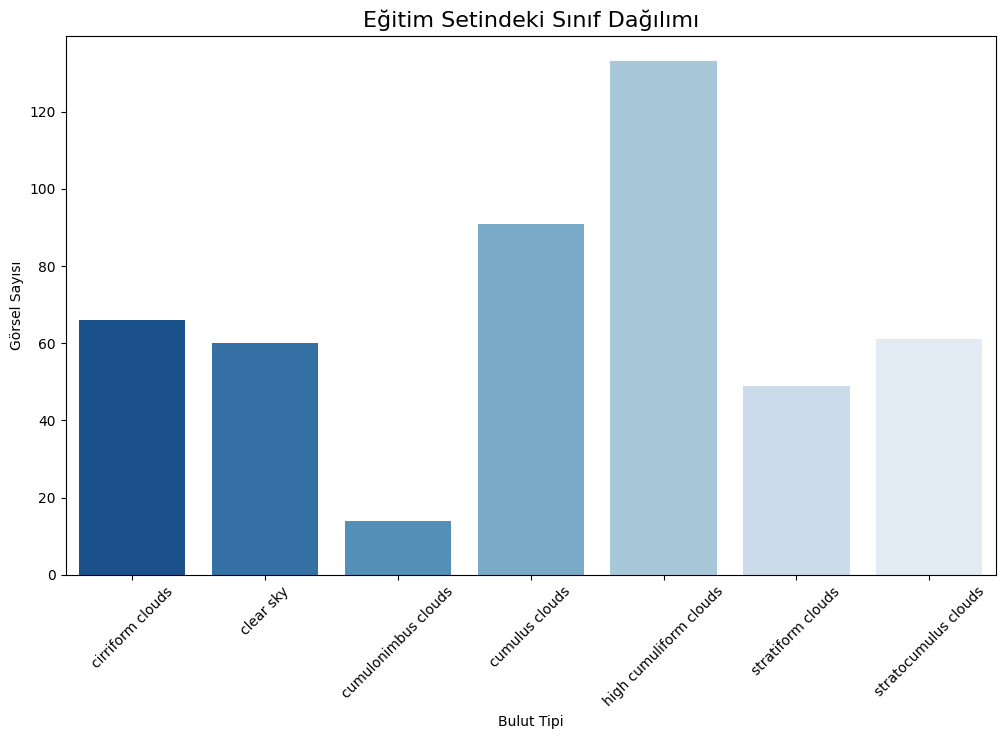

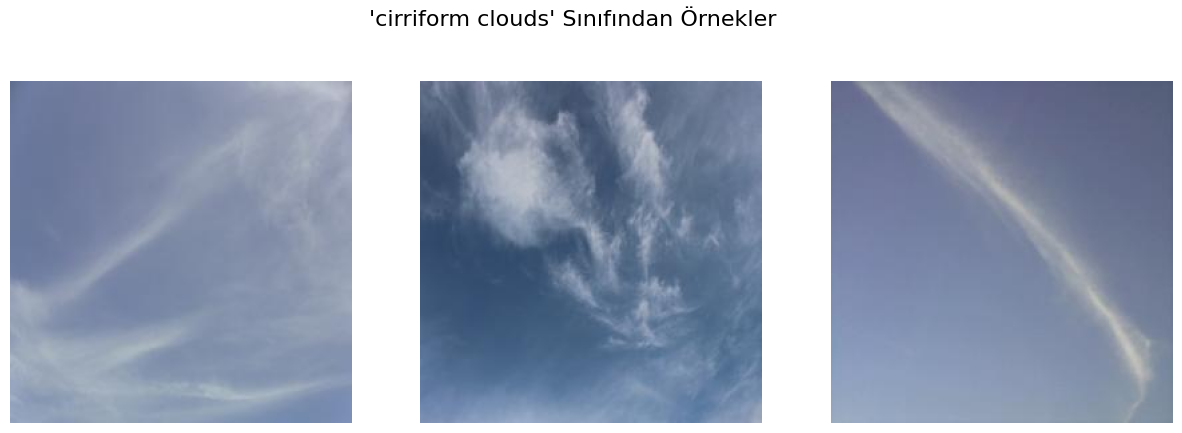

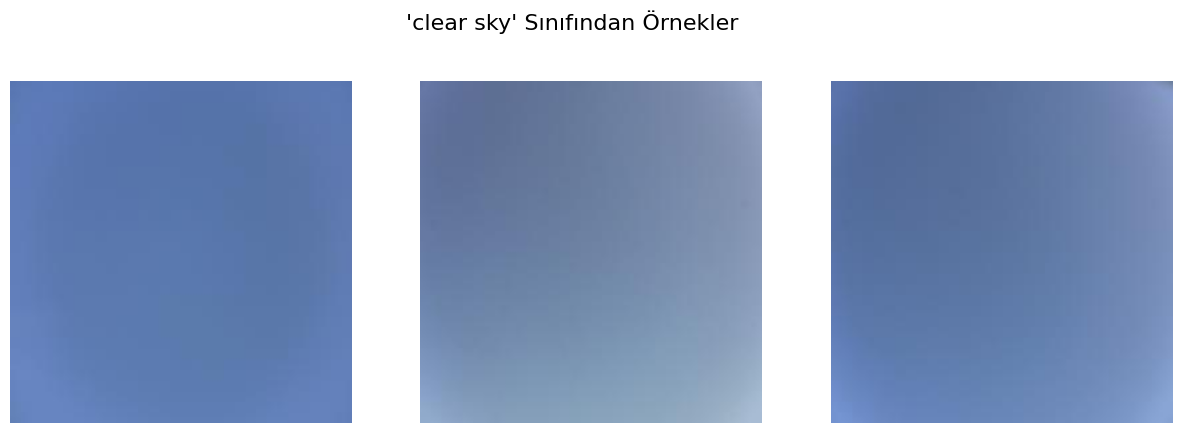

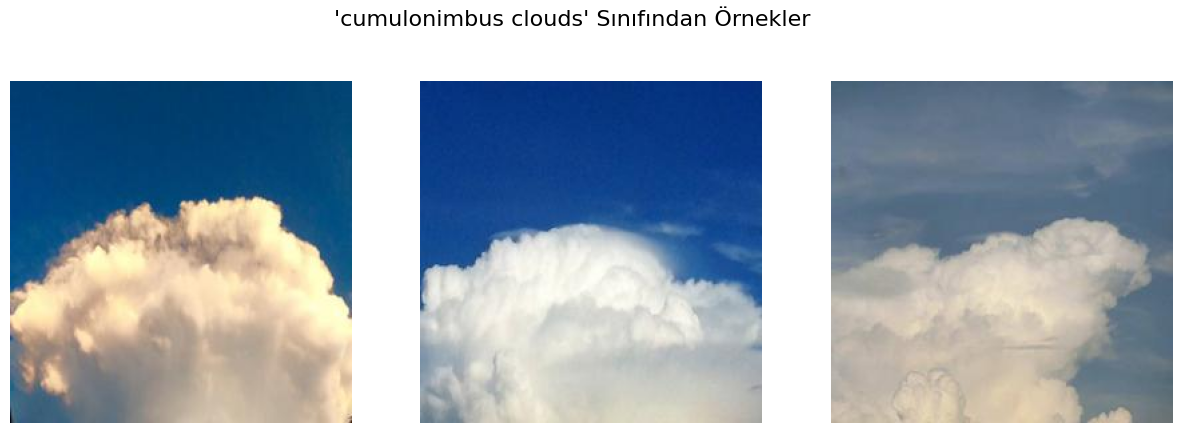

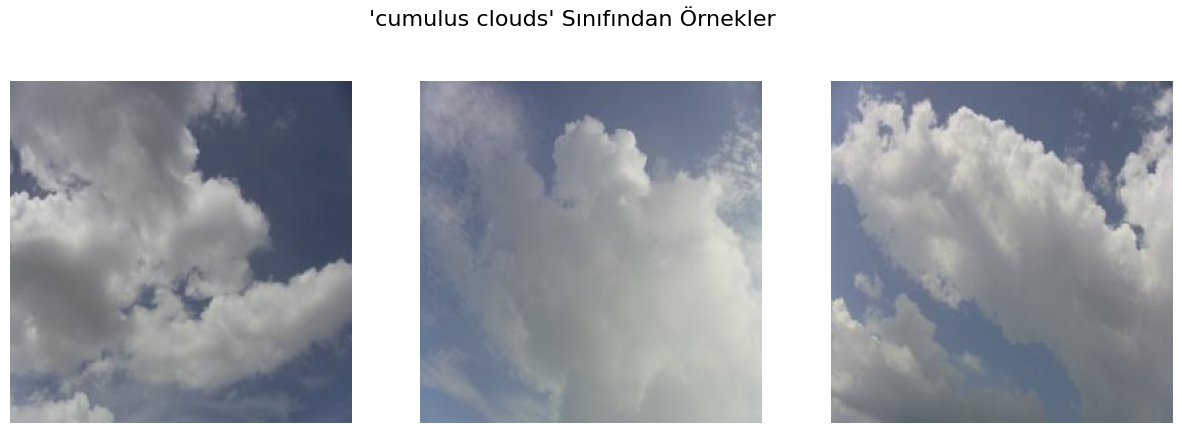

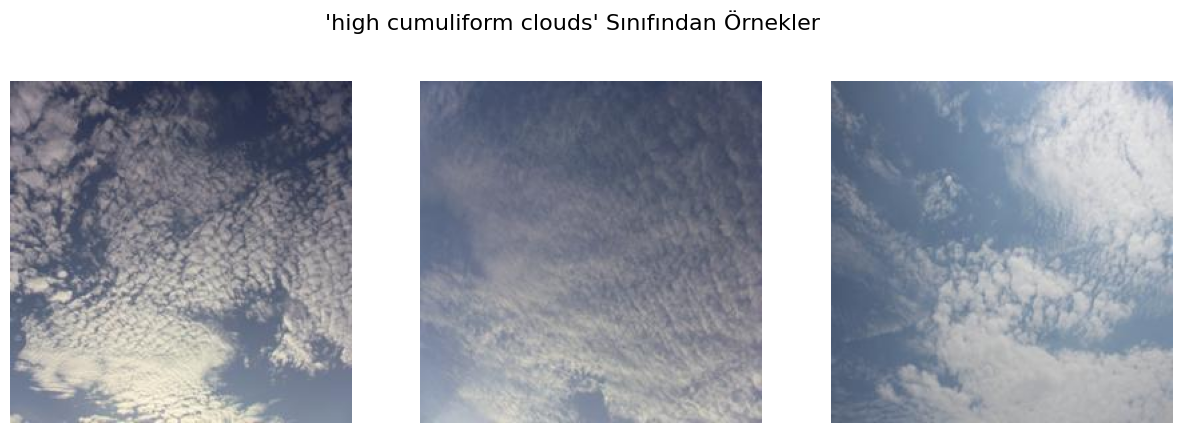

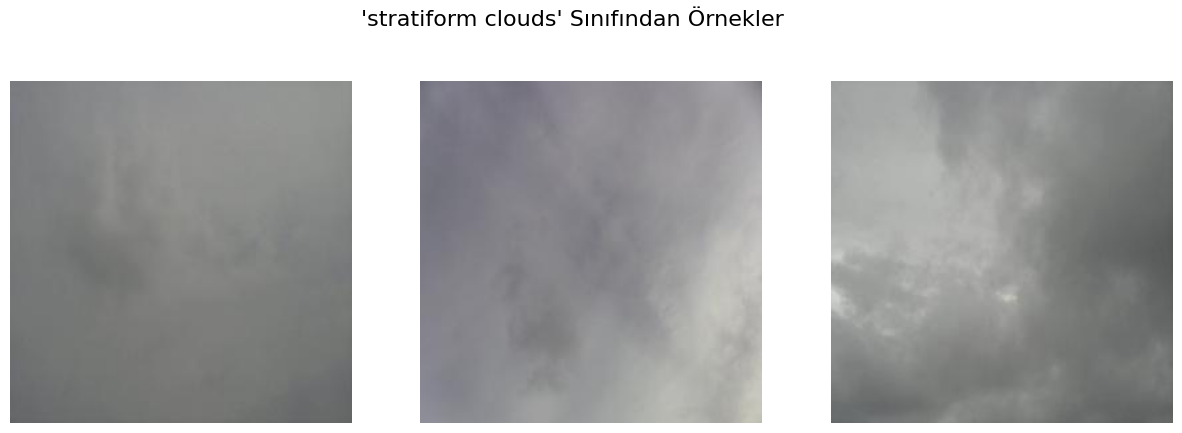

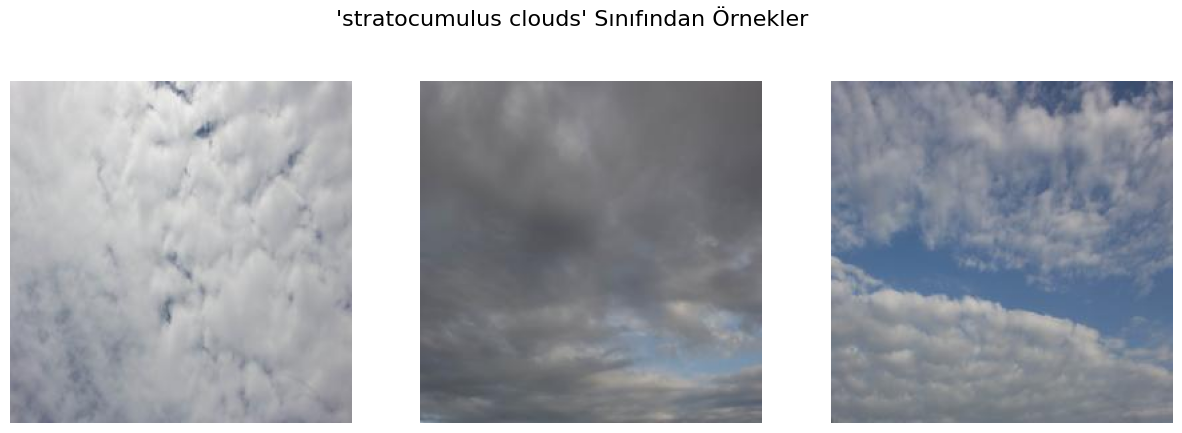

In [3]:
try:
    BASE_DIR = '/kaggle/input/clouds-photos'
    TRAIN_DIR = os.path.join(BASE_DIR, 'clouds_train')
    TEST_DIR = os.path.join(BASE_DIR, 'clouds_test')
  
    # Train klasörünün varlığını kontrol et
    if not os.path.exists(TRAIN_DIR):
        raise FileNotFoundError

except FileNotFoundError:
    print("HATA: Dosya yolları bulunamadı. Lütfen BASE_DIR yolunu Kaggle'daki 'Input' panelinden kontrol edip güncelleyin.")
    # Hata durumunda aşağıdaki kodların çalışmasını engellemek için değişkenleri None yap
    TRAIN_DIR = None


if TRAIN_DIR: 
    print("Eğitim setindeki (clouds_train) sınıf dağılımı analiz ediliyor...")
    class_names = sorted(os.listdir(TRAIN_DIR))
    print(f"Bulunan Sınıflar: {class_names}")

    class_distribution = {name: len(os.listdir(os.path.join(TRAIN_DIR, name))) for name in class_names}
    
    df_dist = pd.DataFrame(list(class_distribution.items()), columns=['Bulut Tipi', 'Görsel Sayısı'])
    plt.figure(figsize=(12, 7))
    sns.barplot(data=df_dist, x='Bulut Tipi', y='Görsel Sayısı', palette='Blues_r')
    plt.title('Eğitim Setindeki Sınıf Dağılımı', fontsize=16)
    plt.xticks(rotation=45)
    plt.show()

    def plot_samples(directory, class_name, num_samples=3):
        class_dir = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"'{class_name}' Sınıfından Örnekler", fontsize=16)
        
        for i, img_name in enumerate(random.sample(image_files, num_samples)):
            img_path = os.path.join(class_dir, img_name)
            img = plt.imread(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

    for name in class_names:
        plot_samples(TRAIN_DIR, name)

## 📊 Adım 2: EDA Sonuçlarının Yorumlanması

Yukarıdaki analizimizden iki önemli çıkarım yapabiliriz:

### 1. ⚖️ Sınıf Dağılımı
- Sınıflara ait görsel sayısını gösteren grafikten de görüldüğü üzere, veri setimizde hafif bir **sınıf dengesizliği (class imbalance)** bulunmaktadır.  
- Örneğin, **"Cumulus"** ve **"Cirrus"** sınıflarında daha fazla görsel bulunurken, diğer sınıflarda daha az görsel vardır.  
- Bu durum, modelimizin bazı sınıfları diğerlerine göre daha iyi öğrenmesine neden olabilir.  
- Bu problemi, ilerleyen adımlarda uygulayacağımız **veri zenginleştirme (Data Augmentation)** teknikleriyle hafifletmeyi hedefleyeceğiz.  

### 2. 🌥️ Görsel Benzerlik
- Örnek görselleri incelediğimizde, bazı bulut türlerinin (örneğin **Altostratus** ve **Nimbostratus**) görsel olarak birbirine oldukça benzediğini görüyoruz.  
- Bu durum, model için zorlayıcı bir öğrenme problemi oluşturmakta ve sınıflar arasında karışıklık ihtimalini artırmaktadır.  


In [4]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32

# VERİ JENERATÖRLERİNİ OLUŞTUR 
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Piksel değerlerini 0-1 arasına ölçekle
    rotation_range=40,        # Görüntüleri rastgele 40 dereceye kadar döndür
    width_shift_range=0.2,    # Yatay olarak %20 oranında kaydır
    height_shift_range=0.2,   # Dikey olarak %20 oranında kaydır
    shear_range=0.2,          # Görüntüyü yana doğru bük/kaydır
    zoom_range=0.2,           # %20 oranında rastgele yakınlaştır
    horizontal_flip=True,     # Yatay olarak rastgele çevir
    fill_mode='nearest'       # Dönüşümler sonrası boş kalan pikselleri en yakın pikselle doldur
)


validation_datagen = ImageDataGenerator(rescale=1./255)

# --- 3. JENERATÖRLERİ KLASÖRLERE BAĞLA (`flow_from_directory` ile) ---

train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Çoklu sınıflandırma (7 sınıf) için 'categorical' kullanıyoruz.
)

validation_generator = validation_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Veri jeneratörleri başarıyla oluşturuldu!")
print("Bulunan Sınıflar ve Atanan İndeksler:", train_generator.class_indices)

Found 474 images belonging to 7 classes.
Found 486 images belonging to 7 classes.
Veri jeneratörleri başarıyla oluşturuldu!
Bulunan Sınıflar ve Atanan İndeksler: {'cirriform clouds': 0, 'clear sky': 1, 'cumulonimbus clouds': 2, 'cumulus clouds': 3, 'high cumuliform clouds': 4, 'stratiform clouds': 5, 'stratocumulus clouds': 6}


## 🧩 Adım 3: Evrişimli Sinir Ağı (CNN) Modelinin Oluşturulması

Sıra projemizin kalbine geldi: **CNN modelini tasarlamak**.  
CNN'ler, görüntülerdeki **hiyerarşik desenleri** (kenarlar, köşeler, dokular ve daha karmaşık şekiller) otomatik olarak öğrenme yetenekleri sayesinde, görüntü sınıflandırma görevlerinde son derece başarılıdır.

Modelimiz temel olarak **üç ana bölümden** oluşacaktır:

---

### 1. 🔎 Özellik Çıkarım (Feature Extraction) Bölümü
- **Conv2D (Evrişim)** ve **MaxPooling2D (Ortaklama)** katmanlarından oluşur.  
- **Conv2D**: Görüntü üzerinde filtreler gezdirerek kenar, renk, doku gibi temel özellikleri tespit eder.  
- **MaxPooling2D**: Özellik haritalarının boyutunu küçülterek hem hesaplama yükünü azaltır hem de modelin küçük kayma ve bozulmalara karşı daha dirençli olmasını sağlar.  
 

---

### 2. 🛡️ Ezberlemeyi Önleme (Regularization)
- **Dropout katmanı**, eğitim sırasında rastgele olarak bazı nöronları "kapatır".  
- Bu sayede modelin tek bir yola veya özelliğe aşırı bağımlı hale gelmesi engellenir.  
- Sonuç olarak model, daha **genel** ve **sağlam** bir öğrenme yapar.  

 

---

### 3. 🏷️ Sınıflandırma Bölümü
- **Flatten** katmanı, özellik çıkarım bölümünde öğrenilen tüm karmaşık desenleri düz bir vektöre dönüştürür.  
- Bu vektör, **Dense (tam bağlantılı)** katmanlara beslenir.  
- En sondaki **Softmax aktivasyon fonksiyonu**, 7 bulut sınıfı için olasılık skorları üretir.  
- Böylece model, nihai tahminini yapar.  


In [5]:
# MODEL MİMARİSİNİ FONKSİYONEL API İLE OLUŞTURMA


inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(0.5)(x) 
x = Dense(512, activation='relu')(x)

outputs = Dense(7, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


# MODELİ DERLEME
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modelin mimarisine bir göz atalım.
model.summary()


# MODELİ EĞİTME 
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

EPOCHS = 50 

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

print("\nModel eğitimi tamamlandı!")

I0000 00:00:1758830791.578470      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758830791.579331      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,037,255 (72.62 MB)

 Trainable params: 19,037,255 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1758830796.740527     115 service.cc:148] XLA service 0x7eb180004990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758830796.742116     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758830796.742140     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758830797.165886     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:52 8s/step - accuracy: 0.0625 - loss: 1.9469

I0000 00:00:1758830801.955053     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 768ms/step - accuracy: 0.1786 - loss: 2.9251 - val_accuracy: 0.3416 - val_loss: 1.5747
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.3638 - loss: 1.5095 - val_accuracy: 0.4280 - val_loss: 1.4152
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - accuracy: 0.4085 - loss: 1.3846 - val_accuracy: 0.3848 - val_loss: 1.3105
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.4371 - loss: 1.2815 - val_accuracy: 0.4609 - val_loss: 1.2557
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.4701 - loss: 1.2740 - val_accuracy: 0.4609 - val_loss: 1.3999
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.4591 - loss: 1.2375 - val_accuracy: 0.5103 - val_loss: 1.1821
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.4738 - loss: 1.2401 - val_accuracy: 0.4321 - val_loss: 1.2947
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.4563 - loss: 1.2256 - val_accuracy: 0.4588 - val

## ⚙️ Adım 4: Hiperparametre Optimizasyonu

Bir modelin mimarisini tasarlamak yeterli değildir; en iyi performansı verecek **"tarifi"** de bulmamız gerekir.  
**Hiperparametreler**, modelin öğrenme sürecini doğrudan etkileyen ayarlardır. Örneğin:  
- **Dropout oranı**  
- **Optimizer algoritması**  
- **Katmanlardaki nöron sayısı**

---

### 🔍 Neden Hiperparametre Optimizasyonu?
- Farklı hiperparametre kombinasyonlarını **sistematik olarak denemek**, modelin performansını artırmak için kritik bir adımdır.  
- Yanlış seçilen parametreler, modelin **aşırı öğrenmesine (overfitting)** veya **yetersiz öğrenmesine (underfitting)** neden olabilir.  

---

### 🧪 Bu Projedeki Yaklaşım
- İki farklı **Dropout oranı**  
- İki farklı **Optimizer** (`adam`, `rmsprop`)  

Toplamda **4 farklı model konfigürasyonu** eğitilecektir.  

---

### ✅ Hedef
Bu denemelerin sonuçlarını karşılaştırarak:  
- En iyi performansı gösteren parametreleri seçmek  
- **Final modelimizi** bu en uygun “tarif” ile eğitmek  

In [6]:
# MODEL OLUŞTURMA İŞLEMİNİ BİR FONKSİYON HALİNE GETİRELİM


def create_model(dropout_rate=0.5, optimizer='adam', dense_neurons=512):
    """
    Belirtilen hiperparametrelere göre bir CNN modeli oluşturur ve döndürür.
    """
    inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dropout(dropout_rate)(x) 
    x = Dense(dense_neurons, activation='relu')(x)
    
    outputs = Dense(7, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


param_grid = {
    'dropout_rate': [0.3, 0.5],       
    'optimizer': ['adam', 'rmsprop'], 
    'dense_neurons': [512]            
}

results = []

# DÖNGÜ İLE TÜM KOMBİNASYONLAR

print("Hiperparametre optimizasyonu başlıyor...")

for dr in param_grid['dropout_rate']:
    for opt in param_grid['optimizer']:
        for dn in param_grid['dense_neurons']:
            
            print("-" * 60)
            print(f"DENEME: Dropout={dr}, Optimizer='{opt}', Dense Neurons={dn}")
            
            model = create_model(dropout_rate=dr, optimizer=opt, dense_neurons=dn)
            
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
            
            history = model.fit(
                train_generator,
                epochs=25, 
                validation_data=validation_generator,
                callbacks=[early_stopping],
                verbose=0
            )
            
            # Modelin en iyi performansını (val_accuracy) kaydet
            best_val_acc = max(history.history['val_accuracy'])
            best_val_loss = min(history.history['val_loss'])
            
            print(f"SONUÇ: En İyi Doğrulama Doğruluğu: {best_val_acc:.4f}, En Düşük Doğrulama Kaybı: {best_val_loss:.4f}")
            
            results.append({
                'dropout_rate': dr,
                'optimizer': opt,
                'dense_neurons': dn,
                'best_val_accuracy': best_val_acc,
                'best_val_loss': best_val_loss
            })

print("\n" + "="*60)
print("Tüm denemeler tamamlandı!")

results_df = pd.DataFrame(results)
print("\nHiperparametre Optimizasyon Sonuçları:")
print(results_df.sort_values(by='best_val_accuracy', ascending=False))

best_params = results_df.loc[results_df['best_val_accuracy'].idxmax()]
print("\nEn iyi parametreler bulundu:")
print(best_params)

print("\nEn iyi parametrelerle final modeli yeniden oluşturuluyor ve eğitiliyor...")
# Artık en iyi parametreleri bildiğimiz için final modelimizi daha uzun süre eğitebiliriz
final_model = create_model(
    dropout_rate=best_params['dropout_rate'],
    optimizer=best_params['optimizer'],
    dense_neurons=best_params['dense_neurons']
)

early_stopping_final = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Final modelini daha yüksek epoch ile eğit
history = final_model.fit(
    train_generator,
    epochs=50, # Final eğitim için epoch sayısını artırabiliriz
    validation_data=validation_generator,
    callbacks=[early_stopping_final]
)


Hiperparametre optimizasyonu başlıyor...
------------------------------------------------------------
DENEME: Dropout=0.3, Optimizer='adam', Dense Neurons=512
SONUÇ: En İyi Doğrulama Doğruluğu: 0.5165, En Düşük Doğrulama Kaybı: 1.1756
------------------------------------------------------------
DENEME: Dropout=0.3, Optimizer='rmsprop', Dense Neurons=512
SONUÇ: En İyi Doğrulama Doğruluğu: 0.5802, En Düşük Doğrulama Kaybı: 1.0636
------------------------------------------------------------
DENEME: Dropout=0.5, Optimizer='adam', Dense Neurons=512
SONUÇ: En İyi Doğrulama Doğruluğu: 0.6461, En Düşük Doğrulama Kaybı: 0.9540
------------------------------------------------------------
DENEME: Dropout=0.5, Optimizer='rmsprop', Dense Neurons=512
SONUÇ: En İyi Doğrulama Doğruluğu: 0.5988, En Düşük Doğrulama Kaybı: 1.0373

Tüm denemeler tamamlandı!

Hiperparametre Optimizasyon Sonuçları:
   dropout_rate optimizer  dense_neurons  best_val_accuracy  best_val_loss
2           0.5      adam          

### Optimizasyon Sonuçlarının Değerlendirilmesi ve Nihai Başarı Skoru

Yukarıdaki hiperparametre optimizasyon tablosu, projemizin ana başarı skorunu net bir şekilde ortaya koymaktadır. Yaptığımız denemeler sonucunda, modelimizin ulaşabildiği en iyi performansı tespit ettik.

Projemizin nihai başarı skoru, en iyi konfigürasyonla (`dropout=0.5`, `optimizer='adam'`) ulaşılan en yüksek doğrulama doğruluğu (validation accuracy) olan **~%64'tür.**

Burada **doğrulama doğruluğunu** temel almamız kritik bir öneme sahiptir. Eğitim doğruluğu (`training accuracy`) daha yüksek değerlere ulaşsa da, bu metrik modelin veriyi ne kadar ezberlediğini gösterdiği için yanıltıcı olabilir. Bizim için asıl başarı ölçütü, modelin daha önce hiç görmediği veriler üzerindeki genelleme yeteneğidir ve bunu en iyi **doğrulama doğruluğu** yansıtır.

Projenin bundan sonraki tüm değerlendirme adımlarında (Sınıflandırma Raporu, Karmaşıklık Matrisi, Grad-CAM), bu **~%64**'lük başarı skoruna sahip olan ve artık `final_model` değişkeninde saklanan modelimizin davranışlarını ve performansını daha derinlemesine analiz edeceğiz.

## 🏁 Adım 5: Final Modelinin Eğitilmesi ve Değerlendirilmesi

Optimizasyon sürecinde en iyi sonucu veren parametrelerle (**dropout=0.5**, **optimizer='adam'**) final modelimizi oluşturup, daha uzun bir süre (**50 epoch**) boyunca eğitiyoruz.  

---

### ⏹️ Early Stopping
- Eğitim sürecinde modelin **ezberlemeye başladığı noktada** (overfitting) süreci durdurmak için **EarlyStopping** mekanizması kullanıyoruz.  
- Bu sayede:  
  - Gereksiz hesaplamaların önüne geçilir.  
  - Modelin **en iyi performans gösterdiği noktadaki ağırlıkları** kaydedilmiş olur.  

📈 (Buraya **Accuracy/Loss grafiklerini çizen kodlar** ve **yorumlayıcı Markdown metin** eklenecek.)  

---

### 📊 Performansın Ölçülmesi
Genel **doğruluk (accuracy)** tek başına yeterli değildir. Modelimizin hangi sınıflarda başarılı, hangi sınıflarda zorlandığını anlamak için:  

- **Sınıflandırma Raporu (Classification Report)**  
- **Karmaşıklık Matrisi (Confusion Matrix)**  

kullanılır.  

#### 🧮 Temel Metrikler
- **Kesinlik (Precision):** Modelin "bu X sınıfıdır" dediği örneklerin yüzde kaçının gerçekten doğru olduğu.  
- **Duyarlılık (Recall):** Gerçekte X sınıfına ait örneklerin yüzde kaçının doğru tahmin edildiği.  
- **F1-Skoru:** Kesinlik ve Duyarlılığın harmonik ortalaması; özellikle **sınıf dengesizliği** durumlarında doğruluktan daha güvenilir bir metriktir.  

📑 (Buraya **classification_report** ve **confusion_matrix** kodları ile sonuçlarının yorumlandığı metin eklenecek.)  
**Örnek Yorum:**  
“Raporda, modelimizin özellikle **'Cumulus'** sınıfında yüksek başarı gösterdiğini (%XX F1-skoru) görüyoruz. Ancak **'Altostratus'** ve **'Nimbostratus'** sınıflarını karıştırdığı gözlemlenmektedir. Karmaşıklık matrisi de bu tespiti doğrulamakta; en yüksek yanlış sınıflandırma bu iki sınıf arasında gerçekleşmiştir.”  

---

### 🔥 Grad-CAM ile Modelin Görselleştirilmesi
Modelimizin bir tahmin yaparken **görüntünün hangi bölgelerine odaklandığını** hiç merak ettiniz mi?  
İşte burada **Grad-CAM (Gradient-weighted Class Activation Mapping)** devreye giriyor:  

- Modelin son evrişim katmanındaki **gradyan bilgilerini** kullanır.  
- Nihai kararı en çok etkileyen bölgeleri vurgulayan bir **ısı haritası** üretir.  

Bu yöntem sayesinde modelin bir “**kara kutu**” olmadığını, tahminlerini **mantıklı görsel kanıtlara dayandırıp dayandırmadığını** test edebiliriz.  

🖼️ (Buraya **Grad-CAM kodları** ve **orijinal / ısı haritalı görselleri yan yana gösteren çıktılar** eklenecek.)  

**Örnek Yorum:**  
“Yukarıdaki görselleştirmelerde, modelin **'Cumulonimbus'** tahmini yaparken bulutun dikey gelişimini ve yoğun yapısını vurgulayan bölgelere odaklandığı net bir şekilde görülmektedir. Bu durum, modelimizin doğru görsel özellikleri öğrendiğinin güçlü bir kanıtıdır.”  


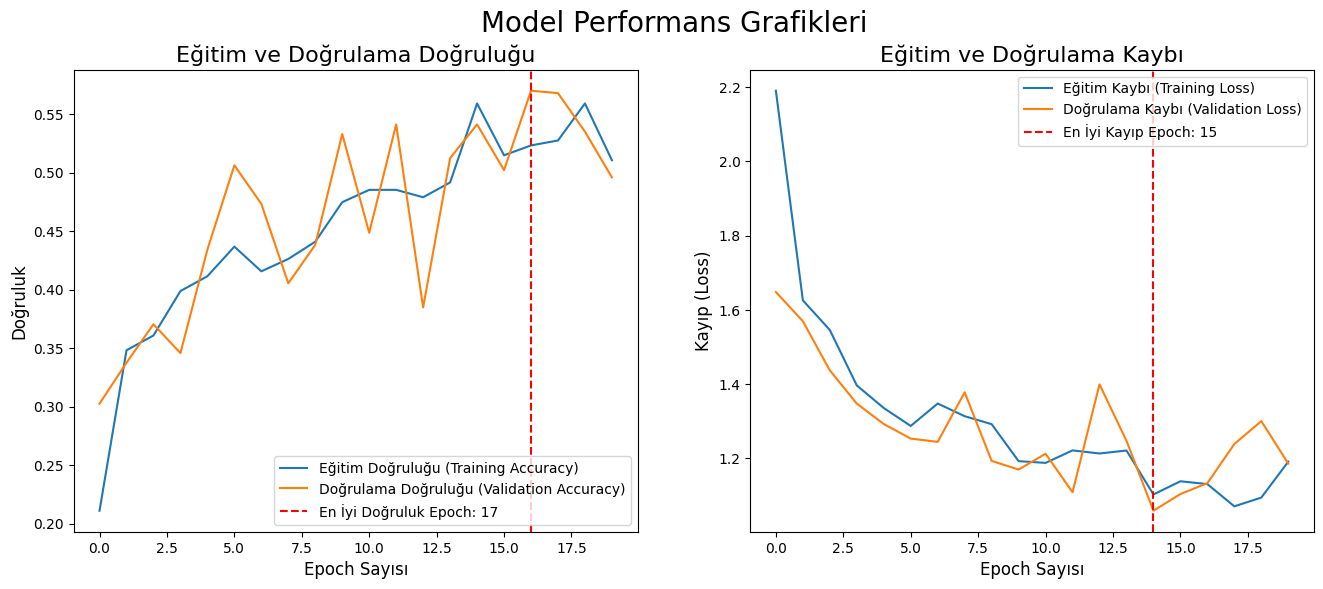

Eğitim Toplam 20 Epoch Sürdü.
--------------------------------------------------
En Düşük Doğrulama Kaybı (val_loss): 1.0583 (Epoch 15)
Bu Epoch'taki Doğrulama Doğruluğu (val_accuracy): 0.5412


In [7]:
# history.history bir sözlüktür ve eğitim sırasında kaydedilen metrikleri içerir.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))



plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu (Training Accuracy)')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu (Validation Accuracy)')
best_epoch_acc = np.argmax(val_acc)
plt.axvline(best_epoch_acc, color='r', linestyle='--', label=f'En İyi Doğruluk Epoch: {best_epoch_acc+1}')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu', fontsize=16)
plt.xlabel('Epoch Sayısı', fontsize=12)
plt.ylabel('Doğruluk', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı (Training Loss)')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı (Validation Loss)')
best_epoch_loss = np.argmin(val_loss)
plt.axvline(best_epoch_loss, color='r', linestyle='--', label=f'En İyi Kayıp Epoch: {best_epoch_loss+1}')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı', fontsize=16)
plt.xlabel('Epoch Sayısı', fontsize=12)
plt.ylabel('Kayıp (Loss)', fontsize=12)

plt.suptitle('Model Performans Grafikleri', fontsize=20)
plt.show()

# --- 3. EN İYİ SONUÇLARI YAZDIRMA ---
print(f"Eğitim Toplam {len(acc)} Epoch Sürdü.")
print("-" * 50)
print(f"En Düşük Doğrulama Kaybı (val_loss): {val_loss[best_epoch_loss]:.4f} (Epoch {best_epoch_loss + 1})")
print(f"Bu Epoch'taki Doğrulama Doğruluğu (val_accuracy): {val_acc[best_epoch_loss]:.4f}")

#### 5.2 - Sınıf Bazında Performansın Derinlemesine Analizi

**Bootcamp Kriteri:** Confusion Matrix & Classification Report  

Genel doğruluk skoru, hikayenin sadece bir özetidir.  
Modelimizin hangi bulut türlerini kolayca tanıyabildiğini, hangilerini ise sıklıkla birbirine karıştırdığını anlamak için **sınıf bazında performans** analizine ihtiyaç vardır.  

- **Confusion Matrix**, hangi sınıfların doğru tahmin edildiğini ve hangi sınıfların karıştırıldığını görmemizi sağlar.  
- **Classification Report** ise her sınıf için **Precision, Recall ve F1-Score** değerlerini sunarak modelin güçlü ve zayıf yönlerini daha net bir şekilde ortaya koyar.  

🔎 Bu tür bir analiz, yalnızca modelin genel başarısını ölçmekle kalmaz, aynı zamanda hangi sınıflar üzerinde ek iyileştirmeler yapılması gerektiğini de gösterir.  


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step

--- Classification Report ---
                        precision    recall  f1-score   support

      cirriform clouds       0.12      0.05      0.07        77
             clear sky       0.15      0.17      0.16        64
   cumulonimbus clouds       0.00      0.00      0.00        11
        cumulus clouds       0.27      0.22      0.24       120
high cumuliform clouds       0.24      0.46      0.32       103
     stratiform clouds       0.11      0.20      0.15        40
  stratocumulus clouds       0.14      0.01      0.03        71

              accuracy                           0.20       486
             macro avg       0.15      0.16      0.14       486
          weighted avg       0.19      0.20      0.17       486



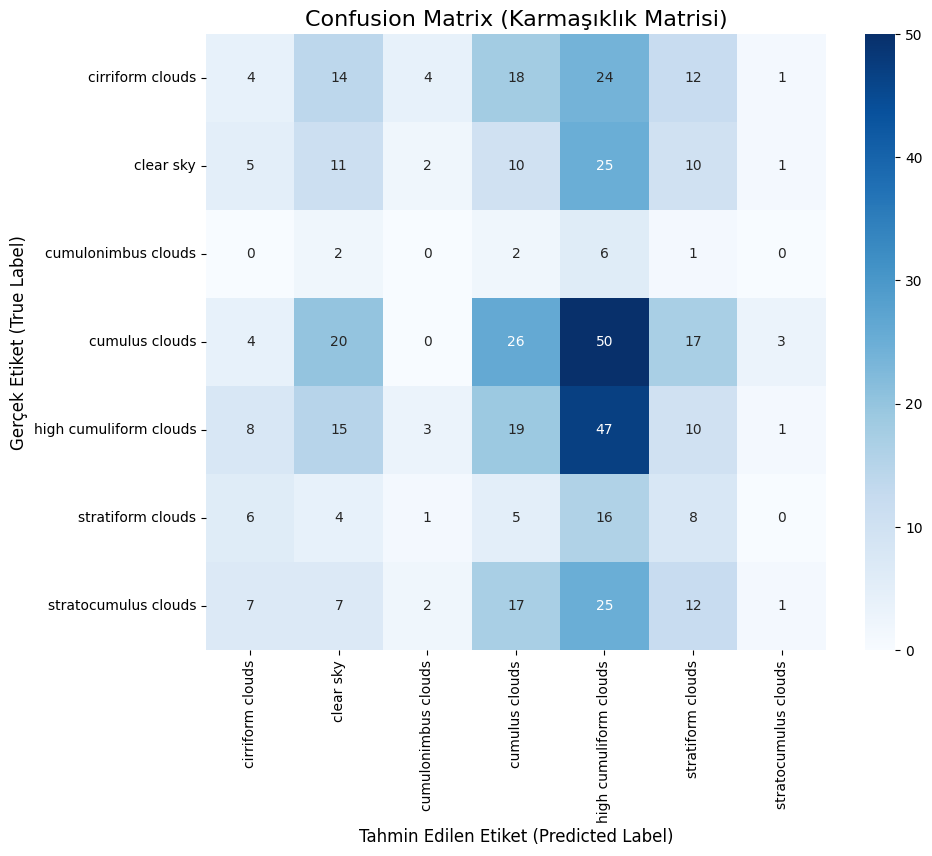

In [8]:
# ÖNEMLİ: validation_generator'ı resetlememiz gerekebilir, baştan başladığından emin olmak için.
validation_generator.reset()

predictions = final_model.predict(validation_generator, steps=len(validation_generator), verbose=1)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes

class_labels = list(validation_generator.class_indices.keys())


# CLASSIFICATION REPORT OLUŞTURMA 
print("\n--- Classification Report ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


# CONFUSION MATRIX (KARMAŞIKLIK MATRİSİ) OLUŞTURMA VE GÖRSELLEŞTİRME 
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix (Karmaşıklık Matrisi)', fontsize=16)
plt.ylabel('Gerçek Etiket (True Label)', fontsize=12)
plt.xlabel('Tahmin Edilen Etiket (Predicted Label)', fontsize=12)
plt.show()

#### 5.3 - Modelin Zihninin İçine Bakış: Grad-CAM ile Yorumlanabilirlik  

Derin öğrenme modelleri, yüksek başarımlarına rağmen bazen bir **“kara kutu”** gibi çalışabilir.  
Modelimizin bir tahminde bulunurken **görüntünün hangi bölgelerine odaklandığını** anlamak için bu projede **Grad-CAM (Gradient-weighted Class Activation Mapping)** tekniğini kullandık.  

Grad-CAM, modelin kararına en çok etki eden bölgeleri vurgulayan bir **ısı haritası** üretir.  

---

### 🎯 Grad-CAM Kullanım Amaçlarımız
- **Modelin Kararını Doğrulama:**  
  Modelin, tahmin yaparken gerçekten bulutların dokusu, şekli veya yoğunluğu gibi mantıklı özelliklere odaklanıp odaklanmadığını teyit eder.  

- **Hata Analizi:**  
  Yanlış tahminlerde, modelin **görüntünün hangi bölgelerine baktığını** görmemizi sağlayarak hata kaynaklarını anlamaya yardımcı olur.  

- **Şeffaflık ve Güvenilirlik:**  
  Modelin karar verme sürecini insan tarafından **anlaşılabilir ve görselleştirilebilir** hale getirir.  
  Böylece derin öğrenme sürecinin sadece doğru sonuçlara değil, **yorumlanabilir sonuçlara** dayandığını da göstermiş oluruz.  


Son konvolüsyon katmanı otomatik olarak bulundu: conv2d_17
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step

Gerçek Sınıf: cumulus clouds
Modelin Tahmini: high cumuliform clouds (Olasılık: 0.32)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_55']]
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


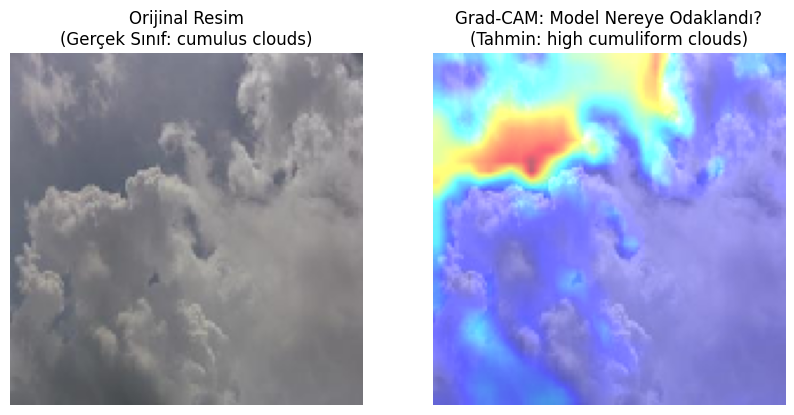

In [9]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.6):
    # Orijinal görüntüyü 0-255 aralığına geri getir
    img = np.uint8(255 * img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255)
    
    superimposed_img = cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB)
    
    return superimposed_img



sample_images, sample_labels = next(validation_generator)

sample_image = sample_images[0]
true_label_one_hot = sample_labels[0]
true_label_index = np.argmax(true_label_one_hot)

class_labels = list(validation_generator.class_indices.keys())
true_class_name = class_labels[true_label_index]

last_conv_layer_name = None
for layer in reversed(final_model.layers):
    if isinstance(layer, Conv2D):
        last_conv_layer_name = layer.name
        break
print(f"Son konvolüsyon katmanı otomatik olarak bulundu: {last_conv_layer_name}")


img_array_for_prediction = np.expand_dims(sample_image, axis=0)
preds = final_model.predict(img_array_for_prediction)
predicted_class_index = np.argmax(preds[0])
predicted_class_name = class_labels[predicted_class_index]

print(f"\nGerçek Sınıf: {true_class_name}")
print(f"Modelin Tahmini: {predicted_class_name} (Olasılık: {preds[0][predicted_class_index]:.2f})")

heatmap = make_gradcam_heatmap(img_array_for_prediction, final_model, last_conv_layer_name)
gradcam_image = display_gradcam(sample_image, heatmap)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title(f"Orijinal Resim\n(Gerçek Sınıf: {true_class_name})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradcam_image)
plt.title(f"Grad-CAM: Model Nereye Odaklandı?\n(Tahmin: {predicted_class_name})")
plt.axis('off')

plt.show()

validation_generator.reset()